# Plotter 3.1
---

In [235]:
import base64
import os, io
import imageio
import pytz
from datetime import date, datetime, timedelta
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import google.cloud.logging
from google.cloud import storage
import logging
from alive_progress import alive_bar

In [223]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../service_account.json'

### Create Date Range 

In [224]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----    CREATE DATERANGE    ----- ----- ----- -----
# Create list of all dates between start_date and end_date
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# ======================================================================

### Truncate CMAP

In [225]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----- ----- ----- -----   TRUNCATE COLORMAP    ----- ----- ----- -----
# Can be used to remove white / black bookended values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
          cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# ======================================================================

### Import Weather Data

In [226]:
# -------------------------------------------------------------------------------
# IMPORT DATASET
# Function to import all weather data
# Data Patching completed in this step
# -------------------------------------------------------------------------------
def import_weather_data(storage_client):
    # Connect to Google Cloud Storage
    # -------------------------------
    storage_client = storage.Client()

    # Open Bucket
    # -----------
    bucket_name = 'weather_aurorabc'
    bucket = storage_client.bucket(bucket_name)

    # Open Blob
    # ---------
    blob_name = 'weather_ampm.csv'
    blob = bucket.blob(blob_name)

    # Read Weather Data from Blob
    # ---------------------------
    with blob.open("r") as f:
        weather_data = pd.read_csv(f)

    # Cast all data variables to float
    weather_data = weather_data.astype(
        {'Height':'float',
        'Temp':'float',
        'Dew_Point':'float',
        'Relative_Humidity':'float',
        'Mixing_Ratio':'float',
        'Wind_Direction':'float',
        'Wind_Speed':'float',
        'Potential_Temp':'float',
        'Equivalent_Potential_Temp':'float',
        'Virtual_Potential_Temp':'float',
        })

    return weather_data

# Find Missing Plots
---

In [234]:
# -------------------------------------------------------------------------------
# FIND MISSING PLOTS
# Function to find any dates with missing plots
# Returns a list of dates to be plot
# -------------------------------------------------------------------------------
def find_missing_plots(storage_client, locations, temp_plot_range, wind_plot_range):
    
    print("Scanning for missing graphs...")
    
    # Create Date Range
    # ~~~~~~~~~~~~~~~~~
    end_date = datetime.today(pytz.timezone("America/Vancouver"))
    start_date = end_date - timedelta(days=90)
    
    search_range = []
    for single_date in daterange(start_date, end_date):
        search_range.append(single_date.date())
                                
    # Define static params
    # ~~~~~~~~~~~~~~~~~~~~
    bucket_name = 'weather_aurorabc'
    bucket = storage_client.bucket(bucket_name)
    plots = ['temp', 'wind']
    
        
    # Search through range of dates for missing graphs
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    missing_dates = []
    for date in search_range:
        if len(missing_dates) >= 5: break
        for loc in locations:
            for plot in plots:
                if plot == 'temp':
                    plot_range = temp_plot_range
                else:
                    plot_range = wind_plot_range
                for r in plot_range:
                    blob_name = 'graphs/{}/{}_{}_{}d_{}.webp'.format(date.strftime("%Y-%m-%d"), loc, plot, r, date.strftime("%Y-%m-%d"))
                    found = storage.Blob(bucket=bucket, name=blob_name).exists(storage_client)
                    if not found:
                        missing_dates.append(date)
                        break
                if date in missing_dates:
                    break
                    
            # Check for windloading GIFs
            blob_name = 'graphs/{}/{}_windloading_{}.gif'.format(date.strftime("%Y-%m-%d"), loc, date.strftime("%Y-%m-%d"))
            if not storage.Blob(bucket=bucket, name=blob_name).exists(storage_client):
                missing_dates.append(date)
                break
            if date in missing_dates:
                break

        
    return missing_dates

# Plot Temps
---
Updated function to plot temperature graphs of varying data ranges for a range of dates for individual locations

In [228]:
# -------------------------------------------------------------------------------
# PLOT TEMPS
# Function to plot temps for a SINGLE LOCATION for a range of dateranges
# Saves graphs to Google Cloud Storage
# -------------------------------------------------------------------------------
def plot_temps(storage_client, location, dates, plot_range):

    for d in dates:
        for r in plot_range:
            
            # Set figure details
            # ~~~~~~~~~~~~~~~~~~
            plt.figure(figsize=(20,6))
            plt.xlim([0, r -1])
            plt.grid()
            plt.axhline(0, color='black')
            plt.xticks(rotation = 'vertical')
            plt.title("Temperature °C - {} day".format(r))
            if r > 30:
                plt.xticks(np.arange(0, r+1, 7.0))

            # Set color palette for the graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            palette = sns.color_palette("Paired", n_colors=6)
            palette_order = [1, 0, 3, 2, 5, 4]
            palette = [palette[idx] for idx in palette_order]
            hue_order = [850, 700]


            # Create new df containing only data within plot range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (location['data']['Date'] >= str(d - timedelta(days=r))) & (location['data']['Date'] <= str(d))
            plot_data = location['data'].loc[mask]
            
            # Calculate IQR for column Temp
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Q1 = plot_data['Temp'].quantile(0.10)
            Q3 = plot_data['Temp'].quantile(0.90)
            IQR = Q3 - Q1

            # Identify and remove outliers
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            threshold = 1.5
            outliers = plot_data[(plot_data['Temp'] < Q1 - threshold * IQR) | (plot_data['Temp'] > Q3 + threshold * IQR)]
            plot_data = plot_data.drop(outliers.index)
            
            # Skip plot if there are no numerical values within the subset
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if plot_data.dropna(subset=['Temp']).empty:
                print("COULD NOT GENERATE GRAPH")
                print("Location: {}".format(location['name']))
                print("Date: {}".format(d))
                print("Plot Range: {}".format(r))
                print("Data: {}\n".format(plot_data))
                continue

            # Plot graph
            # ~~~~~~~~~~
            try:
                g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=plot_data, palette=palette[location['palette_order'][0]: location['palette_order'][1]], hue_order=hue_order)
            except Exception as e:
                print(e)
                print(plot_data)

            # Rename legend with detailed labels
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            l = plt.legend()
            labels = ['850', '700']
            for x, label in enumerate(labels):
                l.get_texts()[x].set_text(label)
                
            # Define save details
            # ~~~~~~~~~~~~~~~~~~~
            save_name = '{}_temp'.format(location['save_name'])
            save_loc = "./figures/temp/{}".format(d.strftime("%Y-%m-%d"))
            if not os.path.isdir(save_loc):
                os.makedirs(save_loc)
                
            # Publish graph to Google Cloud
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            bucket_name = 'weather_aurorabc'
            bucket = storage_client.bucket(bucket_name)

            buff = io.BytesIO()
            plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

            blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(d.strftime("%Y-%m-%d"), save_name, r, d.strftime("%Y-%m-%d"))
            blob = bucket.blob(blob_name)
            blob.upload_from_string(buff.getvalue(), content_type='image/png')
            plt.close()
            del buff

# Plot ALL Temps
---
Updated function to plot temperature graphs of varying data ranges for a range of dates for all locations on a single graph

In [229]:
# -------------------------------------------------------------------------------
# PLOT ALL TEMPS
# Function to plot temps of ALL LOCATIONS for a range of dateranges
# Saves graphs to Google Cloud Storage
# -------------------------------------------------------------------------------
def plot_all_temps(storage_client, locations, dates, plot_range):
    
    for d in dates:
        for r in plot_range:
            
            # Set figure details
            # ~~~~~~~~~~~~~~~~~~
            plt.figure(figsize=(20,6))
            plt.xlim([0, r -1])
            plt.grid()
            plt.axhline(0, color='black')
            plt.xticks(rotation = 'vertical')
            plt.title("Temperature °C - {} day".format(r))
            if r > 30:
                plt.xticks(np.arange(0, r+1, 7.0))
                
            # Set color palette for the graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            palette = sns.color_palette("Paired", n_colors=6)
            palette_order = [1, 0, 3, 2, 5, 4]
            palette = [palette[idx] for idx in palette_order]
            hue_order = [850, 700]
            
            skip = False
            
            # Loop through each location and plot data on graph
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            for location in locations:
                if skip:
                    continue
                # Create truncated data object with only correct date range
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                mask = (location['data']['Date'] >= str(d - timedelta(days=r))) & (location['data']['Date'] <= str(d))
                plot_data = location['data'].loc[mask]
                
                # Calculate IQR for column Temp
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                Q1 = plot_data['Temp'].quantile(0.10)
                Q3 = plot_data['Temp'].quantile(0.90)
                IQR = Q3 - Q1
                
                # Identify and remove outliers
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                threshold = 1.5
                outliers = plot_data[(plot_data['Temp'] < Q1 - threshold * IQR) | (plot_data['Temp'] > Q3 + threshold * IQR)]
                plot_data = plot_data.drop(outliers.index)
                
                # Skip plot if there are no numerical values within the subset
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                if plot_data.dropna(subset=['Temp']).empty:
                    print("COULD NOT GENERATE GRAPH")
                    print("Location: {}".format(location['name']))
                    print("Date: {}".format(d))
                    print("Plot Range: {}".format(r))
                    print("Data: {}\n".format(plot_data))
                    skip = True
                    continue
                

                # Add data for single location to graph
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=plot_data, palette=palette[location['palette_order'][0]: location['palette_order'][1]], hue_order=hue_order)
                
            
            if not skip:
                # Rename legend with detailed labels
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                l = plt.legend()
                labels = []
                for location in locations:
                    for pressure in [700, 850]:
                        labels.append('{} {}'.format(location['name'], pressure))

                labels = [labels[idx] for idx in palette_order]
                for x, label in enumerate(labels):
                    l.get_texts()[x].set_text(label)


                # Generate Save Path
                # ~~~~~~~~~~~~~~~~~~
                save_name = 'all_temp'
                save_loc = "./figures/wind/{}".format(d)
                if not os.path.isdir(save_loc):
                    os.makedirs(save_loc)


                # Publish graph to Google Cloud
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                bucket_name = 'weather_aurorabc'
                bucket = storage_client.bucket(bucket_name)

                buff = io.BytesIO()
                plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

                blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(d.strftime("%Y-%m-%d"), save_name, r, d.strftime("%Y-%m-%d"))
                blob = bucket.blob(blob_name)
                blob.upload_from_string(buff.getvalue(), content_type='image/png')
                plt.close()
                del buff

# Plot Wind
---
Updated function to plot wind graphs of varying data ranges for a range of dates for individual locations

In [230]:
# -------------------------------------------------------------------------------
# PLOT WIND
# Function to plot wind of a SINGLE LOCATION for a range of dateranges
# Saves graphs to Google Cloud Storage
# -------------------------------------------------------------------------------
def plot_wind(storage_client, location, dates, plot_range):
    
    # Define color map and truncate to apropriate range
    cmap = cm.viridis_r
    cmap = truncate_colormap(cmap, minval=0, maxval=0.9)
    
    for d in dates:
        for r in plot_range:
            
            # Create new df containing only data within plot range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (location['data']['Date'] >= str(d - timedelta(days=r))) & (location['data']['Date'] <= str(d))
            plot_data = location['data'].loc[mask]
            
            # Calculate IQR for column Temp
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Q1 = plot_data['Wind_Speed'].quantile(0.05)
            Q3 = plot_data['Wind_Speed'].quantile(0.95)
            IQR = Q3 - Q1

            # Identify and remove outliers
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            threshold = 1.5
            outliers = plot_data[(plot_data['Wind_Speed'] < Q1 - threshold * IQR) | (plot_data['Wind_Speed'] > Q3 + threshold * IQR)]
            plot_data = plot_data.drop(outliers.index)
            plot_data = plot_data.dropna(subset=['Wind_Speed'])
            
            # Skip plot if there are no numerical values within the subset
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if plot_data.empty:
                print("COULD NOT GENERATE GRAPH")
                print("Location: {}".format(location['name']))
                print("Date: {}".format(d))
                print("Plot Range: {}".format(r))
                print("Data: {}\n".format(plot_data))
                continue
                
            # Populate speed and direction vars from DataFrame
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
            wd = plot_data['Wind_Direction'].to_list()
            ws = plot_data['Wind_Speed'].to_list()


            # Plot wind rose for data set
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ax = WindroseAxes.from_ax()
            ax.contourf(wd, ws, bins=np.arange(0, 110, 10), cmap=cmap)
            #ax.contourf(wd, ws, cmap=cmap)
            ax.set_legend()
            
            # Save figure
            # ~~~~~~~~~~~
            plt.title("{} Wind - {} day".format(location['name'], r))
            plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)
            plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
            
            # Generate Save Path
            # ~~~~~~~~~~~~~~~~~~
            save_name = '{}_wind'.format(location['name'].lower().replace(' ', ''))
            save_loc = "./figures/wind/{}".format(d)
            
            if not os.path.isdir(save_loc):
                os.makedirs(save_loc)

            # Save image as webp
            # ~~~~~~~~~~~~~~~~~~
            path = '{}/{}_{}d_{}'.format(save_loc, save_name, r, d)
            plt.savefig('{}.webp'.format(path), format='webp',dpi=150)
            
            # Publish graph to Google Cloud
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            bucket_name = 'weather_aurorabc'
            bucket = storage_client.bucket(bucket_name)

            buff = io.BytesIO()
            plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")

            blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(d, save_name, r, d)
            blob = bucket.blob(blob_name)
            blob.upload_from_string(buff.getvalue(), content_type='image/png')
            plt.close()
            del buff

# Plot Wind Loading
---
Plot the wind loading that has occurred on slope aspects

In [231]:
# -------------------------------------------------------------------------------
# PLOT WIND LOADING
# Function to plot windloading of a SINGLE LOCATION for a range of dateranges
# Combines each graph into a single GIF
# Saves GIF to Google Cloud Storage
# -------------------------------------------------------------------------------
def plot_wind_loading(storage_client, location, dates, plot_range):
    
    # Define color map and truncate to apropriate range
    cmap = cm.viridis_r
    cmap = truncate_colormap(cmap, minval=0, maxval=0.9)
    
    for d in dates:
        images = []
        for r in plot_range:
            
            # Create new df containing only data within plot range
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            mask = (location['data']['Date'] >= str(d - timedelta(days=r))) & (location['data']['Date'] <= str(d))
            plot_data = location['data'].loc[mask]
            
            # Calculate IQR for column Temp
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            Q1 = plot_data['Wind_Speed'].quantile(0.05)
            Q3 = plot_data['Wind_Speed'].quantile(0.95)
            IQR = Q3 - Q1

            # Identify and remove outliers
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            threshold = 1.5
            outliers = plot_data[(plot_data['Wind_Speed'] < Q1 - threshold * IQR) | (plot_data['Wind_Speed'] > Q3 + threshold * IQR)]
            plot_data = plot_data.drop(outliers.index)
            plot_data = plot_data.dropna(subset=['Wind_Speed'])
            plot_data['Wind_Direction'] = plot_data['Wind_Direction'].apply(lambda x: (x+180)%360)
            
            # Skip plot if there are no numerical values within the subset
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if plot_data.empty:
                print("COULD NOT GENERATE GRAPH")
                print("Location: {}".format(location['name']))
                print("Date: {}".format(d))
                print("Plot Range: {}".format(r))
                print("Data: {}\n".format(plot_data))
                continue
                
            # Populate speed and direction vars from DataFrame
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
            wd = plot_data['Wind_Direction'].to_list()
            ws = plot_data['Wind_Speed'].to_list()


            # Plot wind rose for data set
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ax = WindroseAxes.from_ax()
            ax.contourf(wd, ws, bins=np.arange(0, 110, 10), cmap=cmap)
            #ax.contourf(wd, ws, cmap=cmap)
            ax.set_legend()
            
            # Save figure
            # ~~~~~~~~~~~
            plt.title("{} Wind Loading - {} day".format(location['name'], r))
            plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)
            
            # Generate Save Path
            # ~~~~~~~~~~~~~~~~~~
            save_name = '{}_windloading'.format(location['name'].lower().replace(' ', ''))
            save_loc = "./figures/wind/{}".format(d)
            
            if not os.path.isdir(save_loc):
                os.makedirs(save_loc)

            # Save image as webp
            # ~~~~~~~~~~~~~~~~~~
            path = '{}/{}_{}d_{}'.format(save_loc, save_name, r, d)
            plt.savefig('{}.webp'.format(path), format='webp',dpi=150)
            plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
            
            # Publish graph to Google Cloud
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            bucket_name = 'weather_aurorabc'
            bucket = storage_client.bucket(bucket_name)

            buff = io.BytesIO()
            plt.savefig(buff, format='webp',dpi=150, bbox_inches="tight")
            images.append(Image.open(buff))

            #blob_name = 'graphs/{}/{}_{}d_{}.webp'.format(d, save_name, r, d)
            #blob = bucket.blob(blob_name)
            #blob.upload_from_string(buff.getvalue(), content_type='image/webp')
            plt.close()
            del buff
            
            
        def update_img(i):
            im.set_array(images[i])
            return im, 
            
        # Generate Save Path
        # ~~~~~~~~~~~~~~~~~~
        save_name = '{}_windloading'.format(location['name'].lower().replace(' ', ''))
        save_loc = "./figures/wind/{}".format(d)
        if not os.path.isdir(save_loc):
            os.makedirs(save_loc)
            
            
        # Create the figure and axes objects
        fig, ax = plt.subplots()

        # Set the initial image
        im = ax.imshow(images[0], animated=True)

        # Create the animation object
        animation_fig = animation.FuncAnimation(fig, update_img, frames=len(images), interval=200, blit=False,repeat_delay=10)
        
        # Remove unecessary axis
        plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
        for pos in ['right', 'top', 'bottom', 'left']: 
            plt.gca().spines[pos].set_visible(False) 
        
        # Show the animation
        #plt.show()
        #animation_fig.save('{}/{}.gif'.format(save_loc, save_name))
        animation_fig.save('/tmp/{}_{}.gif'.format(save_name, d),bitrate=10)
        
        # Publish graph to Google Cloud
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        bucket_name = 'weather_aurorabc'
        bucket = storage_client.bucket(bucket_name)
        
        
        blob_name = 'graphs/{}/{}_{}.gif'.format(d, save_name, d)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename('/tmp/{}_{}.gif'.format(save_name, d), content_type='image/gif')
        plt.close()    

### Main Application Body

In [232]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----          START         ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#@functions_framework.cloud_event
def main():
    # Collect weather data
    # ~~~~~~~~~~~~~~~~~~~~
    storage_client = storage.Client()
    weather_data = import_weather_data(storage_client)        
    
    # Define location specific params
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    locations = [{
            'name': "Vernon",
            'palette_order': [2, 4], # green
            'save_name': "vernon",
            'data': weather_data[weather_data['Station'] == "Vernon"]
        },
        {
            'name': "Port Hardy",
            'palette_order': [4, 6], # red
            'save_name': "porthardy",
            'data': weather_data[weather_data['Station'] == "Port Hardy"]
        },
        {
            'name': "Quillayute",
            'palette_order': [0, 2], # blue
            'save_name': "quillayute",
            'data': weather_data[weather_data['Station'] == "Quillayute"]
        }]
    
    # Define plot ranges
    # ~~~~~~~~~~~~~~~~~~
    temp_plot_range = [5, 10, 20, 30, 60, 90, 180]
    wind_plot_range = list(range(1, 21))
    
    # Generate list of dates to plot graphs for
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    dates = find_missing_plots(storage_client, [loc['save_name'] for loc in locations], temp_plot_range, wind_plot_range)
    dates.append(datetime.today(pytz.timezone("America/Vancouver")).date())
    dates.reverse()
    #dates = [datetime.today().date()]
    
    with alive_bar(len(dates), force_tty=True) as bar:
        for date in dates:
            print('{} --------------------'.format(date))
            print("Plotting ALL Temps")
            plot_all_temps(storage_client, locations, [date], temp_plot_range)

            for location in locations:
                
                print("Plotting Wind: {}".format(location['name']))
                plot_wind(storage_client, location, [date], wind_plot_range)
                
                print("Plotting Wind Loading: {}".format(location['name']))
                plot_wind_loading(storage_client, location, [date], wind_plot_range)

                print("Plotting Temp: {}\n".format(location['name']))
                plot_temps(storage_client, location, [date], temp_plot_range)
                
                
            bar()
        
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ----- ----- ----- -----           END          ----- ----- ----- -----
#  + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Scanning for missing graphs...
on 0: 2023-12-05 --------------------                                                                                   
on 0: Plotting ALL Temps                                                                                                
on 0: Plotting Wind: Vernon                                                                                             
on 0: Plotting Wind Loading: Vernon                                                                                     


on 0: MovieWriter ffmpeg unavailable; using Pillow instead.


on 0: Plotting Temp: Vernon                                                                                             
on 0: Plotting Wind: Port Hardy                                                                                         
on 0: Plotting Wind Loading: Port Hardy                                                                                 


on 0: MovieWriter ffmpeg unavailable; using Pillow instead.


on 0: Plotting Temp: Port Hardy                                                                                         
on 0: Plotting Wind: Quillayute                                                                                         
on 0: Plotting Wind Loading: Quillayute                                                                                 


on 0: MovieWriter ffmpeg unavailable; using Pillow instead.


on 0: Plotting Temp: Quillayute                                                                                         
on 1: 2023-09-24 --------------------                                                                                   
on 1: Plotting ALL Temps                                                                                                
on 1: Plotting Wind: Vernon                                                                                             
on 1: Plotting Wind Loading: Vernon                                                                                     


on 1: MovieWriter ffmpeg unavailable; using Pillow instead.


on 1: Plotting Temp: Vernon                                                                                             
on 1: Plotting Wind: Port Hardy                                                                                         
on 1: Plotting Wind Loading: Port Hardy                                                                                 


on 1: MovieWriter ffmpeg unavailable; using Pillow instead.


on 1: Plotting Temp: Port Hardy                                                                                         
on 1: Plotting Wind: Quillayute                                                                                         
on 1: Plotting Wind Loading: Quillayute                                                                                 


on 1: MovieWriter ffmpeg unavailable; using Pillow instead.


on 1: Plotting Temp: Quillayute                                                                                         
on 2: 2023-09-24 --------------------                                                                                   
on 2: Plotting ALL Temps                                                                                                
on 2: Plotting Wind: Vernon                                                                                             
on 2: Plotting Wind Loading: Vernon                                                                                     


on 2: MovieWriter ffmpeg unavailable; using Pillow instead.


on 2: Plotting Temp: Vernon                                                                                             
on 2: Plotting Wind: Port Hardy                                                                                         
on 2: Plotting Wind Loading: Port Hardy                                                                                 


on 2: MovieWriter ffmpeg unavailable; using Pillow instead.


on 2: Plotting Temp: Port Hardy                                                                                         
on 2: Plotting Wind: Quillayute                                                                                         
on 2: Plotting Wind Loading: Quillayute                                                                                 


on 2: MovieWriter ffmpeg unavailable; using Pillow instead.


on 2: Plotting Temp: Quillayute                                                                                         
on 3: 2023-09-23 --------------------                                                                                   
on 3: Plotting ALL Temps                                                                                                
on 3: Plotting Wind: Vernon                                                                                             
on 3: Plotting Wind Loading: Vernon                                                                                     


on 3: MovieWriter ffmpeg unavailable; using Pillow instead.


on 3: Plotting Temp: Vernon                                                                                             
on 3: Plotting Wind: Port Hardy                                                                                         
on 3: Plotting Wind Loading: Port Hardy                                                                                 


on 3: MovieWriter ffmpeg unavailable; using Pillow instead.


on 3: Plotting Temp: Port Hardy                                                                                         
on 3: Plotting Wind: Quillayute                                                                                         
on 3: Plotting Wind Loading: Quillayute                                                                                 


on 3: MovieWriter ffmpeg unavailable; using Pillow instead.


on 3: Plotting Temp: Quillayute                                                                                         
on 4: 2023-09-23 --------------------                                                                                   
on 4: Plotting ALL Temps                                                                                                
on 4: Plotting Wind: Vernon                                                                                             
on 4: Plotting Wind Loading: Vernon                                                                                     


on 4: MovieWriter ffmpeg unavailable; using Pillow instead.


on 4: Plotting Temp: Vernon                                                                                             
on 4: Plotting Wind: Port Hardy                                                                                         
on 4: Plotting Wind Loading: Port Hardy                                                                                 


on 4: MovieWriter ffmpeg unavailable; using Pillow instead.


on 4: Plotting Temp: Port Hardy                                                                                         
on 4: Plotting Wind: Quillayute                                                                                         
on 4: Plotting Wind Loading: Quillayute                                                                                 


on 4: MovieWriter ffmpeg unavailable; using Pillow instead.


on 4: Plotting Temp: Quillayute                                                                                         
on 5: 2023-09-22 --------------------                                                                                   
on 5: Plotting ALL Temps                                                                                                
on 5: Plotting Wind: Vernon                                                                                             
on 5: Plotting Wind Loading: Vernon                                                                                     


on 5: MovieWriter ffmpeg unavailable; using Pillow instead.


on 5: Plotting Temp: Vernon                                                                                             
on 5: Plotting Wind: Port Hardy                                                                                         
on 5: Plotting Wind Loading: Port Hardy                                                                                 


on 5: MovieWriter ffmpeg unavailable; using Pillow instead.


on 5: Plotting Temp: Port Hardy                                                                                         
on 5: Plotting Wind: Quillayute                                                                                         
on 5: Plotting Wind Loading: Quillayute                                                                                 


on 5: MovieWriter ffmpeg unavailable; using Pillow instead.


on 5: Plotting Temp: Quillayute                                                                                         
on 6: 2023-09-22 --------------------                                                                                   
on 6: Plotting ALL Temps                                                                                                
on 6: Plotting Wind: Vernon                                                                                             
on 6: Plotting Wind Loading: Vernon                                                                                     


on 6: MovieWriter ffmpeg unavailable; using Pillow instead.


on 6: Plotting Temp: Vernon                                                                                             
on 6: Plotting Wind: Port Hardy                                                                                         
on 6: Plotting Wind Loading: Port Hardy                                                                                 


on 6: MovieWriter ffmpeg unavailable; using Pillow instead.


on 6: Plotting Temp: Port Hardy                                                                                         
on 6: Plotting Wind: Quillayute                                                                                         
on 6: Plotting Wind Loading: Quillayute                                                                                 


on 6: MovieWriter ffmpeg unavailable; using Pillow instead.


on 6: Plotting Temp: Quillayute                                                                                         
on 7: 2023-09-18 --------------------                                                                                   
on 7: Plotting ALL Temps                                                                                                
on 7: Plotting Wind: Vernon                                                                                             
on 7: Plotting Wind Loading: Vernon                                                                                     


on 7: MovieWriter ffmpeg unavailable; using Pillow instead.


on 7: Plotting Temp: Vernon                                                                                             
on 7: Plotting Wind: Port Hardy                                                                                         
on 7: Plotting Wind Loading: Port Hardy                                                                                 


on 7: MovieWriter ffmpeg unavailable; using Pillow instead.


on 7: Plotting Temp: Port Hardy                                                                                         
on 7: Plotting Wind: Quillayute                                                                                         
on 7: Plotting Wind Loading: Quillayute                                                                                 


on 7: MovieWriter ffmpeg unavailable; using Pillow instead.


on 7: Plotting Temp: Quillayute                                                                                         
on 8: 2023-09-18 --------------------                                                                                   
on 8: Plotting ALL Temps                                                                                                
on 8: Plotting Wind: Vernon                                                                                             
on 8: Plotting Wind Loading: Vernon                                                                                     


on 8: MovieWriter ffmpeg unavailable; using Pillow instead.


on 8: Plotting Temp: Vernon                                                                                             
on 8: Plotting Wind: Port Hardy                                                                                         
on 8: Plotting Wind Loading: Port Hardy                                                                                 


on 8: MovieWriter ffmpeg unavailable; using Pillow instead.


on 8: Plotting Temp: Port Hardy                                                                                         
on 8: Plotting Wind: Quillayute                                                                                         
on 8: Plotting Wind Loading: Quillayute                                                                                 


on 8: MovieWriter ffmpeg unavailable; using Pillow instead.


on 8: Plotting Temp: Quillayute                                                                                         
on 9: 2023-09-17 --------------------                                                                                   
on 9: Plotting ALL Temps                                                                                                
on 9: Plotting Wind: Vernon                                                                                             
on 9: Plotting Wind Loading: Vernon                                                                                     


on 9: MovieWriter ffmpeg unavailable; using Pillow instead.


on 9: Plotting Temp: Vernon                                                                                             
on 9: Plotting Wind: Port Hardy                                                                                         
on 9: Plotting Wind Loading: Port Hardy                                                                                 


on 9: MovieWriter ffmpeg unavailable; using Pillow instead.


on 9: Plotting Temp: Port Hardy                                                                                         
on 9: Plotting Wind: Quillayute                                                                                         
on 9: Plotting Wind Loading: Quillayute                                                                                 


on 9: MovieWriter ffmpeg unavailable; using Pillow instead.


on 9: Plotting Temp: Quillayute                                                                                         
on 10: 2023-09-17 --------------------                                                                                  
on 10: Plotting ALL Temps                                                                                               
on 10: Plotting Wind: Vernon                                                                                            
on 10: Plotting Wind Loading: Vernon                                                                                    


on 10: MovieWriter ffmpeg unavailable; using Pillow instead.


on 10: Plotting Temp: Vernon                                                                                            
on 10: Plotting Wind: Port Hardy                                                                                        
|████████████▏⚠︎                          | (!) 10/33 [30%] in 18:10.4 (0.01/s)                                          


ServiceUnavailable: 503 POST https://storage.googleapis.com/upload/storage/v1/b/weather_aurorabc/o?uploadType=multipart: Service Unavailable: ('Request failed with status code', 503, 'Expected one of', <HTTPStatus.OK: 200>)

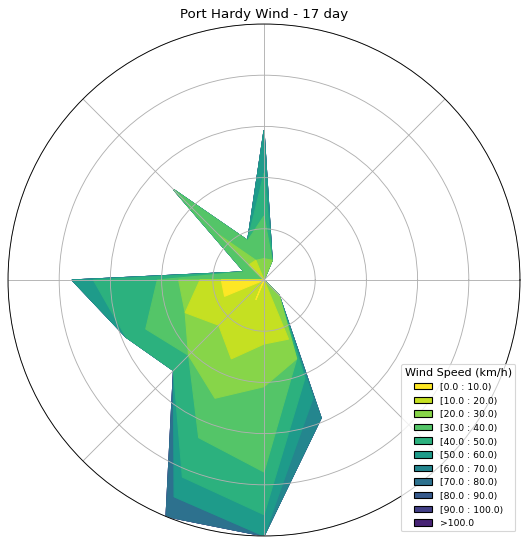

In [233]:
main()